<a href="https://colab.research.google.com/github/ldesdunes/tensorflow2/blob/master/Stock_Market_Trading_Syn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/joanby/tensorflow2/blob/master/Collab%208%20-%20Reinforcement%20Learning%20para%20problemas%20de%20Stock%20Market%20Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Paso 1: Instalar las dependencias y configurar el entorno

In [ ]:
#!pip install tensorflow-gpu==2.0.0.alpha0
%tensorflow_version 2.x

In [ ]:
#!pip install pandas-datareader

## Paso 2: Importar las dependencias del proyecto

In [ ]:
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
#import pandas_datareader as data_reader

from tqdm import tqdm_notebook, tqdm
from collections import deque

import statsmodels.graphics.tsaplots as sgt 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
tf.__version__

'2.6.0'

## Paso 3: Construir la red neuronal de la AI del Trader 

In [ ]:
class AI_Trader():
  
  def __init__(self, state_size, action_space=3, model_name="AITrader"): #Manten, Compra, Vende
    
    self.state_size = state_size
    self.action_space = action_space
    self.memory = deque(maxlen=2000)
    self.inventory = []
    self.model_name = model_name
    
    self.gamma = 0.95
    self.epsilon = 1.0
    self.epsilon_final = 0.01
    self.epsilon_decay = 0.995
    
    self.model = self.model_builder()
    
  def model_builder(self):
    
    model = tf.keras.models.Sequential()    
    model.add(tf.keras.layers.Dense(units=32, activation='relu', input_dim=self.state_size))    
    model.add(tf.keras.layers.Dense(units=64, activation='relu'))    
    model.add(tf.keras.layers.Dense(units=128, activation='relu'))    
    model.add(tf.keras.layers.Dense(units=self.action_space, activation='linear'))    
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=0.001))
    
    return model
  
  def trade(self, state):
    
    if random.random() <= self.epsilon:
      return random.randrange(self.action_space)
    
    actions = self.model.predict(state)
    return np.argmax(actions[0])
  
  
  def batch_train(self, batch_size):
    
    batch = []
    for i in range(len(self.memory) - batch_size + 1, len(self.memory)):
      batch.append(self.memory[i])
      
    for state, action, reward, next_state, done in batch:
      reward = reward
      if not done:
        reward = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
        
      target = self.model.predict(state)
      target[0][action] = reward
      
      self.model.fit(state, target, epochs=1, verbose=0)
      
    if self.epsilon > self.epsilon_final:
      self.epsilon *= self.epsilon_decay

## Paso 4: Pre procesado del dataset

### Definir las funciones adicionales

#### Sigmoide

In [ ]:
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

#### Función de formato de precios

In [ ]:
def stocks_price_format(n):
  if n < 0:
    return "- $ {0:2f}".format(abs(n))
  else:
    return "$  {0:2f}".format(abs(n))

#### Carga del dataset

In [ ]:
def dataset_loader(stock_name):
  
  #Complete the dataset loader function
  #dataset = data_reader.DataReader(stock_name, data_source="yahoo")
  
  dataset = pd.read_csv('https://raw.githubusercontent.com/ldesdunes/tensorflow2/master/datasets/aapl.csv')
  
  #ld: Esto es para disminuir rows en pruebas
  dataset = dataset[:int(len(dataset)/3)]

  start_date = str(dataset.index[0]).split()[0]
  end_date = str(dataset.index[-1]).split()[0]
  
  close = dataset['Close']

  return close #, Volume

### State creator

In [ ]:
def state_creator(data, timestep, window_size):
  
  starting_id = timestep - window_size + 1
  
  if starting_id >= 0:
    windowed_data = list(data[starting_id:timestep+1])
  else:
    windowed_data = - starting_id * [data[0]] + list(data[0:timestep+1])

  #ld: Convertir en estacionaria la serie
  #df = pd.DataFrame(windowed_data)
  #windowed_data = df.diff().fillna(0)[0]

  state = []
  for i in range(window_size - 1):
    state.append(sigmoid(windowed_data[i+1] - windowed_data[i]))
    
  return np.array([state])

#state_creator(data, 0, 18)

### Cargar una divisa de mercado

In [ ]:
#stock_name = "AAPL"
stock_name = "BTC-USD"
data = dataset_loader(stock_name)

### Pruebas & analisis de los datos

#### Encontrar el mejor retroceso

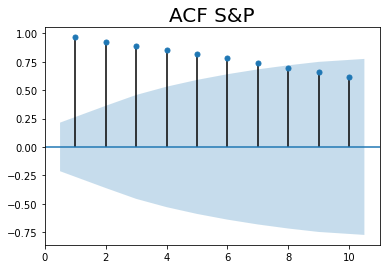

In [ ]:
df = data #data.diff(0)
sgt.plot_acf(df, lags = 10, zero = False)
plt.title("ACF S&P", size = 20)
plt.show()

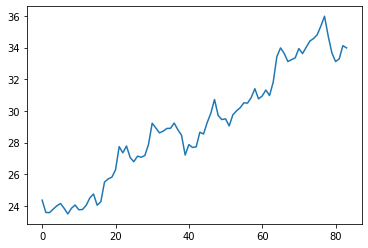

In [ ]:
df.plot()

## Paso 5: Entrenar la AI Trader

### Configurar los hyper parámetros

In [ ]:
window_size = 7
episodes = 1000

batch_size = 32
data_samples = len(data) - 1

### Definir el modelo del AI Trader

In [ ]:
trader = AI_Trader(window_size)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#trader.model.summary()

### Bucle de entrenamiento

In [ ]:
for episode in range(1, episodes + 1):
  
  print("Episodio: {}/{}".format(episode, episodes))
  
  state = state_creator(data, 0, window_size + 1)
  
  total_profit = 0
  trader.inventory = []
  
  for t in tqdm(range(data_samples)):
    
    action = trader.trade(state)
    
    next_state = state_creator(data, t+1, window_size + 1)
    reward = 0
    
    if action == 1: #Compra
      trader.inventory.append(data[t])
      print("AI Trader compró: ", stocks_price_format(data[t]))
      
    elif action == 2 and len(trader.inventory) > 0: #Vende
      buy_price = trader.inventory.pop(0)
      
      reward = max(data[t] - buy_price, 0)
      total_profit += data[t] - buy_price
      print("AI Trader vendió: ", stocks_price_format(data[t]), " Beneficio: " + stocks_price_format(data[t] - buy_price), 'Total: '+ stocks_price_format(total_profit) )
      
    if t == data_samples - 1:
      done = True
    else:
      done = False
      
    trader.memory.append((state, action, reward, next_state, done))
    
    state = next_state
    
    if done:
      print("########################")
      print("BENEFICIO TOTAL: {}".format(total_profit))
      print("########################")
    
    if len(trader.memory) > batch_size:
      trader.batch_train(batch_size)
      
  if episode % 10 == 0:
    trader.model.save("ai_trader_{}.h5".format(episode))
    